# Parareal coupling FDTDs of different resolution

In [1]:
using PyPlot
using IterativeSolvers

#### Define Finite Difference scheme

In [2]:
L = 2.0*pi;
N = 201;
X = linspace(0.,L,N)';
k = 5;
u = exp.(-4*(X-pi).^2+im*k*(X-pi)).';
ut = zeros(N);

In [3]:
function fdtd_wave(u0,ut0,X,t_final)

    c = 1.0;
    
    dx = X[2]-X[1];
    dt = dx/5;
    
    u =u0;
    ut=ut0;
    
    N = size(X,2);

    time = collect(0:dt:t_final);  # time array
    lamda2 = c*dt/dx;
    
    B = spdiagm((ones(N-1),-2*ones(N),ones(N-1)), (-1,0,1))/dx^2;
    B[1,N] = 1.0/dx^2;
    B[N,1] = 1.0/dx^2;
    
    h(y,prevy,yxx) = 2*y-prevy + c^2*dt^2*yxx;
    preu = zeros(N);
    
    for t = time
        # time advancement
        if ( t == 0.0 )
            u = u+dt*ut;
            preu = u[:];
        else
            tempu = u;
            uxx = B*u;
            u = h(u,preu,uxx);
            preu = tempu;
        end
    end
    ut=(u-preu)/dt;
    
    return (u,ut)

end

fdtd_wave (generic function with 1 method)

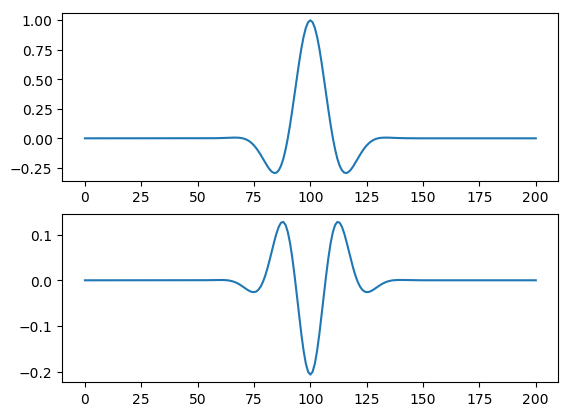

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000234EB160>

In [4]:
u1,ut1=fdtd_wave(u,ut,X,0.01);
subplot(2,1,1)
plot(real(u1))
subplot(2,1,2)
plot(real(ut1))

#### Define parareal scheme

In [46]:
function wave1dparareal(u0,ut0)
    t_final = 2.0;
    dT = 0.05;
    time = collect(0:dT:t_final);
    Nt = size(time,1);
    Nx = size(u0,1);
    
    u  = complex(zeros(Nx,Nt));
    ut = complex(zeros(Nx,Nt));
    
    u[:,1]  = u0;
    ut[:,1] = ut0;
    
    xs = linspace(0.,L,N)';
    Xs = linspace(0.,L,N)';
    
    # initial parareal guess
    for i=2:Nt
        u[:,i],ut[:,i]=fdtd_wave(u[:,i-1],ut[:,i-1],Xs,dT);
    end
    
    # parareal iteration
    pimax=0;
    cfu_update = zeros(Nx,Nt);
    cfut_update= zeros(Nx,Nt);
    for pi=1:pimax
        # PARALLEL COMPUTATION
        for i=2:Nt
            u_fine,ut_fine     = fdtd_wave(u[:,i-1],ut[:,i-1],xs,dT);
            u_coarse,ut_coarse = fdtd_wave(u[:,i-1],ut[:,i-1],Xs,dT);
            
            cfu_update[:,i]  = u_fine   -  u_coarse;
            cfut_update[:,i] = ut_fine  -  ut_coarse;
        end
        
        # SERIAL UPDATE
        for i=2:Nt
            u[:,i],ut[:,i]=fdtd_wave(u[:,i-1],ut[:,i-1],Xs,dT);
            
            u[:,i] =u[:,i]+cfu_update[:,i];
            ut[:,i]=ut[:,i]+cfut_update[:,i];
        end       
        
    end
    
    return (u,ut)
    
end

wave1dparareal (generic function with 2 methods)

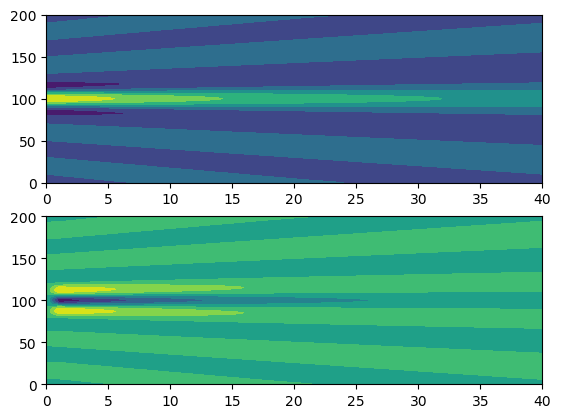

PyObject <matplotlib.contour.QuadContourSet object at 0x00000000343086D8>

In [47]:
u2,ut2=wave1dparareal(u,ut);
subplot(2,1,1)
contourf(real(u2))
subplot(2,1,2)
contourf(real(ut2))